# Capstone: Elo competetion

* [General functions and parameters](#general_function)
* [Handling merchant data](#merchant_data)
* [Handling transaction data](#transaction_data)
* [Handling training and testing data](#training_data)
* [Modeling](#modeling)

## Summary
In this note book I will perform feature engineering and stacking ensemble on the [Elo merchant category recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation). Some part of the codes in this notebook is taken from [this excellent notebook](https://www.kaggle.com/fabiendaniel/elo-world) of [FabienDaniel](https://www.kaggle.com/fabiendaniel)


In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LarsCV, RidgeCV, Lars
import warnings
import random
import datetime
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import catboost as cb
import scipy
from sklearn.cluster import DBSCAN
from pandas.api.types import is_numeric_dtype


from keras import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
np.random.seed(1)
random.seed(1)
import time
import gc

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8,4)
rcParams['font.size'] = 12

<a id='general_function'></a>

## General functions and parameters

In [3]:
DEBUG = False
REF_DATE = datetime.datetime.strptime('2018-12-31', '%Y-%m-%d')

In [4]:
def skip_func(i, p=0.1, debug=DEBUG):
    if debug == True:
        return (i>0 and random.random()>p)
    else:
        return False

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def print_null(df):
    for col in df:
        if df[col].isnull().any():
            print('%s has %.0f null values: %.3f%%'%(col, df[col].isnull().sum(), df[col].isnull().sum()/df[col].count()*100))

In [7]:
def impute_na(X_train, df, variable):
    # make temporary df copy
    temp = df.copy()
    
    # extract random from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(), random_state=0, replace=True)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(), variable] = random_sample
    return temp[variable]

In [8]:
# Clipping outliers
def clipping_outliers(X_train, df, var):
    IQR = X_train[var].quantile(0.75)-X_train[var].quantile(0.25)
    lower_bound = X_train[var].quantile(0.25) - 6*IQR
    upper_bound = X_train[var].quantile(0.75) + 6*IQR
    no_outliers = len(df[df[var]>upper_bound]) + len(df[df[var]<lower_bound])
    print('There are %i outliers in %s: %.3f%%' %(no_outliers, var, no_outliers/len(df)))
    df[var] = df[var].clip(lower_bound, upper_bound)
    return df

<a id='merchant_data'></a>

## Merchant data
### Import and overview

In [9]:
df_merchants = pd.read_csv('./merchants.csv.zip', 
                            skiprows=lambda i: skip_func(i,p=1))

In [10]:
df_merchants.head()

merchant_id  merchant_group_id  merchant_category_id  subsector_id  \
0  M_ID_838061e48c               8353                   792             9   
1  M_ID_9339d880ad               3184                   840            20   
2  M_ID_e726bbae1e                447                   690             1   
3  M_ID_a70e9c5f81               5026                   792             9   
4  M_ID_64456c37ce               2228                   222            21   

   numerical_1  numerical_2 category_1 most_recent_sales_range  \
0    -0.057471    -0.057471          N                       E   
1    -0.057471    -0.057471          N                       E   
2    -0.057471    -0.057471          N                       E   
3    -0.057471    -0.057471          Y                       E   
4    -0.057471    -0.057471          Y                       E   

  most_recent_purchases_range  avg_sales_lag3  ...  avg_sales_lag6  \
0                           E           -0.40  ...           -2.25   
1                           E           -0.72  ...           -0.74   
2                           E          -82.13  ...          -82.13   
3                           E             NaN  ...             NaN   
4                           E             NaN  ...             NaN   

   avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
0           18.666667                   6            -2.32   
1            1.291667                   6            -0.57   
2          260.000000                   2           -82.13   
3            4.666667                   6              NaN   
4            0.361111                   6              NaN   

   avg_purchases_lag12  active_months_lag12  category_4  city_id state_id  \
0            13.916667                   12           N      242        9   
1             1.687500                   12           N       22       16   
2           260.000000                    2           N       -1        5   
3             3.833333                   12           Y       -1       -1   
4             0.347222                   12           Y       -1       -1   

   category_2  
0         1.0  
1         1.0  
2         5.0  
3         NaN  
4         NaN  

[5 rows x 22 columns]

In [11]:
print('Merchant data types')
df_merchants.dtypes

Merchant data types


merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [12]:
df_merchants = df_merchants.replace([np.inf,-np.inf], np.nan)
print('Merchants null')
print_null(df_merchants)

Merchants null
avg_sales_lag3 has 13 null values: 0.004%
avg_purchases_lag3 has 3 null values: 0.001%
avg_sales_lag6 has 13 null values: 0.004%
avg_purchases_lag6 has 3 null values: 0.001%
avg_sales_lag12 has 13 null values: 0.004%
avg_purchases_lag12 has 3 null values: 0.001%
category_2 has 11887 null values: 3.682%


In [13]:
print('Merchants unique values')
df_merchants[['merchant_id','merchant_group_id','merchant_category_id','subsector_id','category_1','most_recent_sales_range','most_recent_purchases_range','merchant_category_id',
         'active_months_lag3','active_months_lag6','category_4','category_2']].nunique()

Merchants unique values


merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
merchant_category_id              324
active_months_lag3                  3
active_months_lag6                  6
category_4                          2
category_2                          5
dtype: int64

### Preprocessing

#### Filling null

Fill `ave_sales` with most frequent values. Fill `category_2` with random sampling from available data


In [14]:
# Average sales null
null_cols = ['avg_purchases_lag3','avg_sales_lag3', 'avg_purchases_lag6','avg_sales_lag6','avg_purchases_lag12','avg_sales_lag12']
for col in null_cols:
    df_merchants[col] = df_merchants[col].fillna(df_merchants[col].mean())

# Category 2
df_merchants['category_2'] = impute_na(df_merchants, df_merchants, 'category_2')

#### Discretize and mapping data

All `avg_sales` and `avg_purchases` data is discretized into 5 categories, following the 5 categories of most recent values

In [15]:
# Sales cut
sales_cut = df_merchants['most_recent_sales_range'].value_counts().sort_values(ascending=False).values
sales_cut = sales_cut/np.sum(sales_cut)
for i in range(1,len(sales_cut)):
    sales_cut[i] = sales_cut[i]+sales_cut[i-1]
    
# Purchases cut
purchases_cut = df_merchants['most_recent_purchases_range'].value_counts().sort_values(ascending=False).values
purchases_cut = purchases_cut/np.sum(purchases_cut)
for i in range(1,len(purchases_cut)):
    purchases_cut[i] = purchases_cut[i]+purchases_cut[i-1]

In [16]:
# Discretize data
discretize_cols = ['avg_purchases_lag3','avg_sales_lag3', 'avg_purchases_lag6','avg_sales_lag6','avg_purchases_lag12','avg_sales_lag12']

for col in discretize_cols:
    categories = pd.qcut(df_merchants[col].values,sales_cut, duplicates='raise').categories.format()
    df_merchants[col], intervals = pd.qcut(df_merchants[col], 5, labels=['A','B','C','D','E'], retbins=True, duplicates='raise')
    print('Discretize for %s:'%col)
    print(categories)

Discretize for avg_purchases_lag3:
['(1.0270000000000001, 1.377]', '(1.377, 4.333]', '(4.333, 21.334]', '(21.334, 61851.333]']
Discretize for avg_sales_lag3:
['(1.0090000000000001, 1.46]', '(1.46, 5.88]', '(5.88, 37.73]', '(37.73, 851844.64]']
Discretize for avg_purchases_lag6:
['(1.0410000000000001, 1.571]', '(1.571, 6.778]', '(6.778, 39.042]', '(39.042, 56077.5]']
Discretize for avg_sales_lag6:
['(1.0190000000000001, 1.69]', '(1.69, 9.46]', '(9.46, 71.63]', '(71.63, 1513959.0]']
Discretize for avg_purchases_lag12:
['(1.06, 1.683]', '(1.683, 8.455]', '(8.455, 51.5]', '(51.5, 50215.556]']
Discretize for avg_sales_lag12:
['(1.0390000000000001, 1.81]', '(1.81, 11.71]', '(11.71, 92.041]', '(92.041, 2567408.0]']


In [17]:
# Mapping data
df_merchants['category_1'] = df_merchants['category_1'].map({'Y':1, 'N':0})
df_merchants['category_4'] = df_merchants['category_4'].map({'Y':1, 'N':0})

map_cols = discretize_cols + ['most_recent_purchases_range', 'most_recent_sales_range']
for col in map_cols:
    df_merchants[col] = df_merchants[col].map({'A':5,'B':4,'C':3,'D':2,'E':1})

Text(0.5, 1.0, 'Pair-wise correlation')

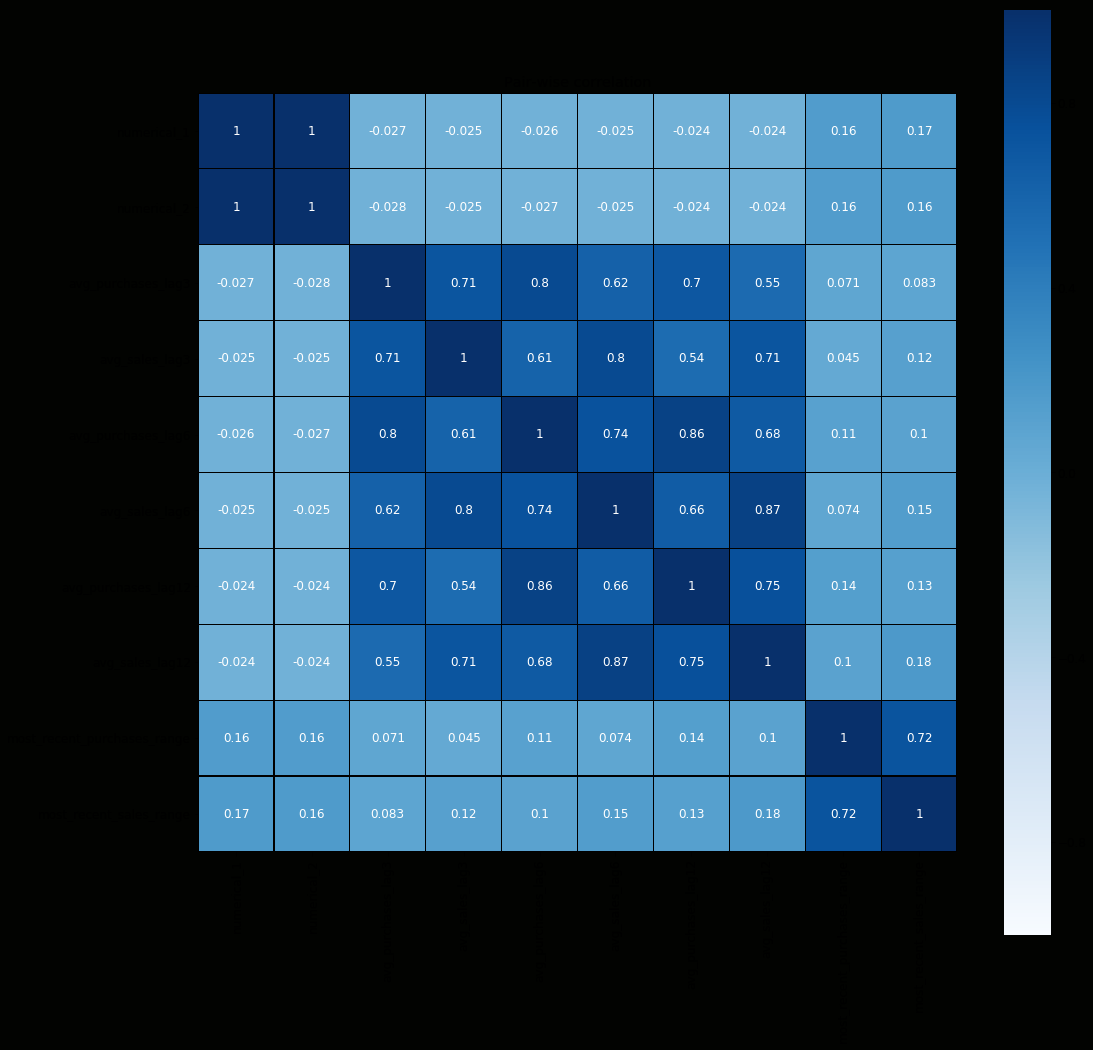

In [20]:
numeric_cols = ['numerical_1','numerical_2']+map_cols

colormap = plt.cm.Blues
ax = plt.figure(num=None, figsize=(17, 17), facecolor='#020301', edgecolor='k')

sns.heatmap(df_merchants[numeric_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='k', annot=True)
ax.set_facecolor('#020301')



    
    
# Be sure to specify facecolor or it won't look right in Illustrator
ax.savefig(col + ".png",dpi = ax.dpi, facecolor=ax.get_facecolor(), transparent=True)
plt.title('Pair-wise correlation')

#### Handling numerical data

There are 28532 outliers in numerical_1: 0.085%
There are 25860 outliers in numerical_2: 0.077%
There are 0 outliers in category_2: 0.000%
There are 0 outliers in category_4: 0.000%
Unique values:
numerical_1    8
numerical_2    8
category_2     5
category_4     2
dtype: int64


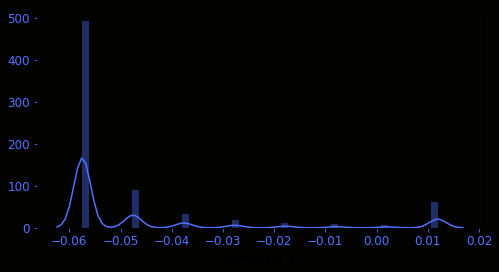

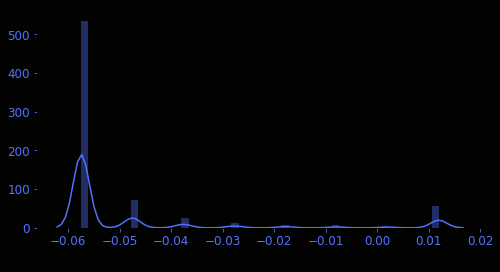

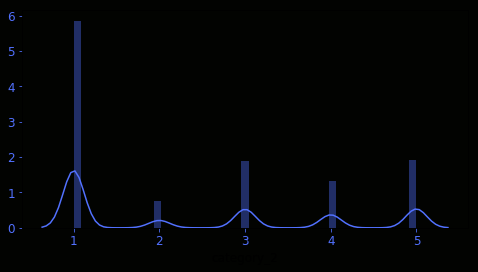

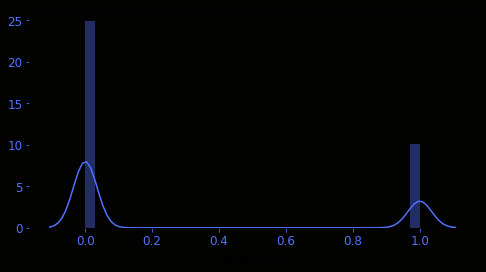

In [21]:
numerical_cols = ['numerical_1','numerical_2', 'category_2', 'category_4']
for col in numerical_cols:
    df_merchants = clipping_outliers(df_merchants, df_merchants, col)
    # Specify facecolor when creating the figure
    fig, ax = plt.subplots(facecolor='#020301')
    sns.distplot(df_merchants[col], color='#5271ff')
   
# Specify background color for the axis/plot
    ax.set_facecolor('#020301')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#5271ff')
    ax.tick_params(axis='y', colors='#5271ff')
    
    
# Be sure to specify facecolor or it won't look right in Illustrator
    fig.savefig(col + "_mer.png",dpi = fig.dpi, facecolor=fig.get_facecolor(), transparent=True)
    
    del ax
   
print('Unique values:')
print(df_merchants[numerical_cols].nunique())

In [22]:
df_merchants

merchant_id  merchant_group_id  merchant_category_id  \
0       M_ID_838061e48c               8353                   792   
1       M_ID_9339d880ad               3184                   840   
2       M_ID_e726bbae1e                447                   690   
3       M_ID_a70e9c5f81               5026                   792   
4       M_ID_64456c37ce               2228                   222   
5       M_ID_a0915f62b5              20201                    87   
6       M_ID_bfd41933db              33861                   792   
7       M_ID_d8ff08219e              16430                   529   
8       M_ID_c5b389236d              37179                   813   
9       M_ID_d2162ed113             112122                    81   
10      M_ID_492cfa500c              13462                   369   
11      M_ID_73487fed26              17123                   427   
12      M_ID_7149162139               2118                    63   
13      M_ID_a31332e0bc              15040                   427   
14      M_ID_c9eb20f6f5              25449                    45   
15      M_ID_c9855bf3e3                321                   690   
16      M_ID_c929bb59af               9514                     2   
17      M_ID_dd3ae3de10              30534                   278   
18      M_ID_dc671140d0              21536                   278   
19      M_ID_7551d55443              16010                   298   
20      M_ID_a8effe9197                577                   497   
21      M_ID_39643c7d93              22146                   309   
22      M_ID_07930b58ae              11559                   705   
23      M_ID_e16b20b50a                 35                   511   
24      M_ID_0f0334c393              39020                   437   
25      M_ID_2be211b847                 35                   456   
26      M_ID_0fa16b39ed                 35                   781   
27      M_ID_69618a786a               4760                   703   
28      M_ID_3c87a47f6b              38953                   703   
29      M_ID_c44ccc8110               4274                   278   
...                 ...                ...                   ...   
334666  M_ID_82a30d9203                 35                   705   
334667  M_ID_076cd8a829                401                   665   
334668  M_ID_a0bec1c066               2897                   840   
334669  M_ID_79692349d6               3097                   491   
334670  M_ID_96ba3c7b60                 35                   690   
334671  M_ID_77e2942cd8                 35                   705   
334672  M_ID_2637773dd2                 35                   683   
334673  M_ID_b5b80addf5                176                   705   
334674  M_ID_c9a8f296ae             108130                   561   
334675  M_ID_d855771cd9                 35                   278   
334676  M_ID_b1fc88154d                321                   705   
334677  M_ID_ed8064314e                840                   437   
334678  M_ID_98b342c0e3                 35                    80   
334679  M_ID_b98db225f5                 35                   705   
334680  M_ID_004995eae1             112528                   705   
334681  M_ID_7159aca3bf                 35                   574   
334682  M_ID_a62e20132d             112393                   248   
334683  M_ID_c1a7024db1                565                   705   
334684  M_ID_981fe24744                771                   690   
334685  M_ID_f86439cec0                 35                   278   
334686  M_ID_3111c6df35             107283                   690   
334687  M_ID_ca4d18b336               1145                   437   
334688  M_ID_59764e8cb1              17285                   309   
334689  M_ID_5ba019a379                 35                    80   
334690  M_ID_a9d91682ad                 35                   241   
334691  M_ID_1f4773aa76               1145                   705   
334692  M_ID_725a60d404                 35                   544   


After clipping outliers, there are only 5 uniques values left in these two columns. Thus, we map them into 3 categories: the lowest: `0`, the middle: `1`, and the extreme: `2`

In [23]:
for col in numerical_cols:
    b = df_merchants[col].unique()
    df_merchants[col] = df_merchants[col].apply(lambda x: 0 if x==b[0] else (1 if x in b[1:4] else 2))

In [24]:
df_merchants = df_merchants.drop(columns=['avg_purchases_lag3','avg_sales_lag3', 'avg_purchases_lag6','avg_sales_lag6'])

In [25]:
df_merchants = reduce_mem_usage(df_merchants)

Mem. usage decreased to  9.58 Mb (79.2% reduction)


In [26]:
# Rename col
for col in df_merchants.columns:
    if col != 'merchant_id':
        df_merchants = df_merchants.rename(index=str, columns={col:'mer_'+col})

<a id='transaction_data'></a>

## Transaction data

### Import and merge transaction data

In [27]:
df_hist_trans = pd.read_csv('./historical_transactions.csv.zip')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:

df_trans = reduce_mem_usage(df_hist_trans)


In [ ]:
df_trans.head()

In [ ]:
# Merge with merchant data
df_trans = pd.merge(df_trans, df_merchants, how='left', left_on='merchant_id', right_on='merchant_id')

#if DEBUG == False:
    #del df_merchants
    #gc.collect()

In [ ]:
df_trans.head()

In [ ]:
for col in df_trans.columns:
    if df_trans[col].nunique()<=15 & df_trans[col].nunique()>=2:
        fig, ax = plt.subplots(facecolor='#020301')
        sns.countplot(df_trans[col])
   
# Specify background color for the axis/plot
        ax.set_facecolor('#020301')
        ax.set_clip_on(False)
        ax.tick_params(axis='x', colors='#5271ff')
        ax.tick_params(axis='y', colors='#5271ff')
        
    
# Be sure to specify facecolor or it won't look right in Illustrator
        fig.savefig(col + "4.png", facecolor=fig.get_facecolor(), transparent=True)
    


In [ ]:
print('Null ratio')
print_null(df_trans)

Unique values:
purchase_amount    75190
dtype: int64


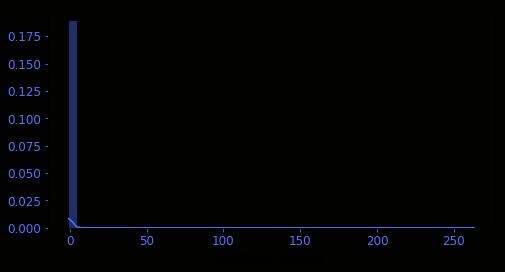

In [80]:
numerical_cols = ['purchase_amount']
for col in numerical_cols:
   
    fig, ax = plt.subplots(facecolor='#020301')
    sns.distplot(df_new_trans[col], color='#5271ff')
   
# Specify background color for the axis/plot
    ax.set_facecolor('#020301')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#5271ff')
    ax.tick_params(axis='y', colors='#5271ff')
    
    
# Be sure to specify facecolor or it won't look right in Illustrator
    fig.savefig(col + "_hist.png",dpi = fig.dpi, facecolor=fig.get_facecolor(), transparent=True)
    
   
print('Unique values:')
print(df_new_trans[numerical_cols].nunique())

In [ ]:
#print('Unique values')
#df_trans[['card_id','city_id','category_1','city_id','category_1','installments','category_3','merchant_id','merchant_category_id',
         #'month_lag','category_2','state_id','subsector_id','days_to_date']].nunique()

Some columns are duplicated and can be dropped

In [ ]:
# Drop duplicate columns
df_trans = reduce_mem_usage(df_trans)
df_trans = df_trans.drop(columns=['mer_city_id', 'mer_state_id', 'mer_category_1', 'mer_category_2',
                          'mer_merchant_category_id','mer_subsector_id'])

### Filling null and encoding

In [ ]:
# Fill null by most frequent data
df_trans['category_2'].fillna(1.0,inplace=True)
df_trans['category_3'].fillna('A',inplace=True)


# Fill null by random sampling
nan_cols = df_trans.columns[df_trans.isna().any()].tolist()
for col in nan_cols:
    df_trans[col] = impute_na(df_trans, df_trans, col)

In [ ]:
# Encoding
df_trans['authorized_flag'] = df_trans['authorized_flag'].map({'Y':1,'N':0})
df_trans['category_1'] = df_trans['category_1'].map({'Y':1,'N':0})
dummies = pd.get_dummies(df_trans[['category_2', 'category_3']], prefix = ['cat_2','cat_3'], columns=['category_2','category_3'])
df_trans = pd.concat([df_trans, dummies], axis=1)

In [ ]:
df_trans.head()


### Knowledge-based features

* Weekend or not
* Hour of the day: categorize into Morning (5 to 12), Afternoon (12 to 17), Evening (17 to 22) and Night (22 to 5) 
* Day of month: categorize into Early (<10), Middle (>10 and <20) and Late (>20)
* Time to christmas 2017 and time to Black Friday 2017 (purchase amount increase significantly around this time)

In [ ]:
df_merchants.head()

In [ ]:
'''
**Does authorize flag matter?**

In lots of other kernels, transaction data are splitted into two: authorized transaction and  un-authorized transaction. Let's see if there's a significant impact in doing that
    
There are no obvious difference between authorized and unauthorized transaction, thus we will NOT split transaction data into two separate sets.
'''

In [ ]:
'''
# Categorical features
compare_cols = ['category_1', 'category_2', 'category_3', 'installments', 'mer_most_recent_sales_range',
               'mer_most_recent_purchases_range', 'mer_active_months_lag3', 'mer_active_months_lag6', 'mer_active_months_lag12',
               'mer_category_4', 'weekend','hour']
for col in compare_cols:
    fig = plt.figure()
    sns.countplot(x=col, hue='authorized_flag', data=df_trans)
'''

In [ ]:
'''
# Numerical features
compare_cols = ['purchase_amount','months_to_date','mer_numerical_1','mer_numerical_2','mer_avg_sales_lag3',
               'mer_avg_purchases_lag3', 'mer_avg_sales_lag6', 'mer_avg_purchases_lag6', 'mer_avg_sales_lag12',
               'mer_avg_purchases_lag12']
for col in compare_cols:
    fig = plt.figure()
    temp_authorized = df_trans[col][df_trans['authorized_flag']==1]
    temp_unauthorized = df_trans[col][df_trans['authorized_flag']==0]
    sns.kdeplot(data=np.log(temp_unauthorized), label='unauthorized')
    sns.kdeplot(data=np.log(temp_authorized), label='authorized')
    plt.title('log-scale '+col)
    
if DEBUG==False:
    del temp_authorized,temp_unauthorized
    gc.collect()
'''

### Aggregating features

In [ ]:
def most_frequent(agg_df, df, col):
    temp = df.groupby('card_id')[col].value_counts().index
    agg_df

In [ ]:
def most_frequent(x):
    return x.value_counts().index[0]

In [ ]:
def aggregate_trans(df):
    agg_func = {
        'category_1': ['sum'],
        'cat_2_1.0': ['sum'],
        'cat_2_2.0': [ 'sum'],
        'cat_2_3.0': ['sum'],
        'cat_2_4.0': ['sum'],
        'cat_2_5.0': ['sum'],
        'cat_3_A': ['sum'],
        'cat_3_B': ['sum'],
        'cat_3_C': ['sum'],
        'mer_numerical_1':['nunique','mean','std'],
        'mer_most_recent_sales_range': ['mean','std'],
        'mer_most_recent_purchases_range': ['mean','std'],
        'mer_avg_sales_lag12':['mean','std'],
        'mer_avg_purchases_lag12':['mean','std'],
        'mer_active_months_lag12':['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['mean', 'min', 'max']
    }
    # 'authorized_flag': ['mean', 'std'],
    #'mer_category_4': ['mean'],
    #'mer_avg_sales_lag6':['nunique', 'mean','std'],
    #'mer_avg_purchases_lag6':['nunique', 'mean','std'],
    #'months_to_date': ['mean', 'max', 'min', 'std'],
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = ['_'.join(col)for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    return agg_df

In [ ]:
'''
def aggregate_per_month(df):
    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max'],
        'installments': ['sum', 'mean', 'min', 'max'],
        'merchant_id': ['nunique'],
        'state_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'subsector_id': ['nunique']
    }
    agg_df = df.groupby(['card_id','months_to_date']).agg(agg_func)
    agg_df.columns = ['_'.join(col)for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    for col in agg_df.columns:
        if col != 'card_id':
            agg_df = agg_df.rename(index=str, columns={col:'monthly_'+col})
    final_group = agg_df.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col)for col in final_group.columns.values]
    final_group = final_group.drop(columns=['monthly_months_to_date_mean','monthly_months_to_date_std'])
    final_group.reset_index(inplace=True)
    return final_group
'''

#### Splitting authorize and unthorize data

In [ ]:
# Use when not splitting authorize/unauthorize
agg_df = aggregate_trans(df_trans)
auth_trans = df_trans.groupby('card_id')['authorized_flag'].mean().reset_index()
if DEBUG==False:
    del df_trans
    gc.collect
agg_df = reduce_mem_usage(agg_df)

agg_df = agg_df.replace([np.inf,-np.inf], np.nan)
print_null(agg_df)
agg_df = agg_df.fillna(value=0)


### Repeat all previous step with new transaction data

In [74]:
print('Importing new transaction data ...')
df_new_trans = pd.read_csv('./new_merchant_transactions.csv.zip', 
                           skiprows=lambda i: skip_func(i), parse_dates=['purchase_date'])

Importing new transaction data ...


In [75]:
df_new_trans.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_415bb3a509      107          N             1   
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.557574 2018-03-11 14:57:36         1.0         9            19  
1        -0.569580 2018-03-19 18:53:37         1.0         9            19  
2        -0.551037 2018-04-26 14:08:44         1.0         9            14  
3        -0.671925 2018-03-07 09:43:21         NaN        -1             8  
4        -0.659904 2018-03-22 21:07:53         NaN        -1            29

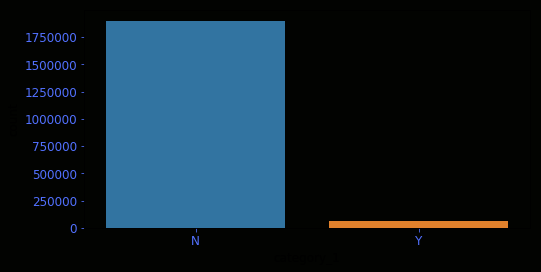

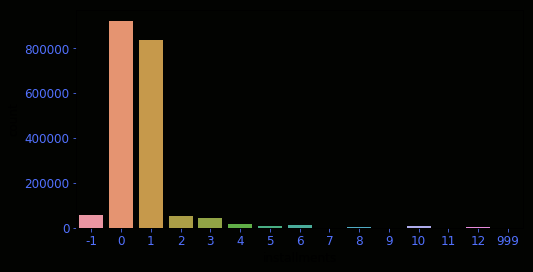

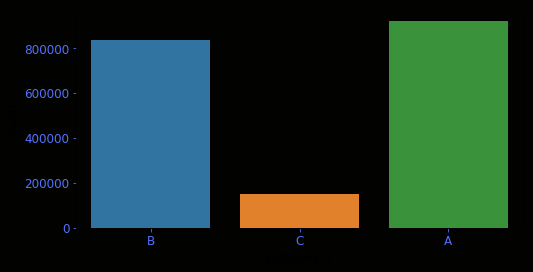

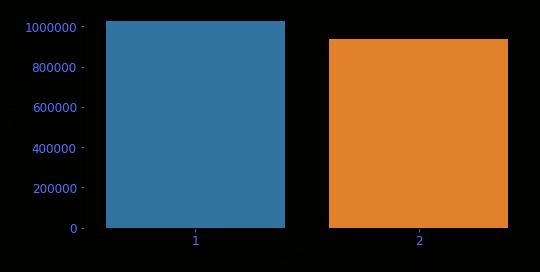

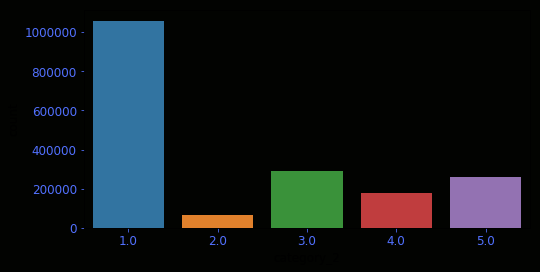

In [76]:
for col in df_new_trans.columns:
    if df_new_trans[col].nunique()<=15 & df_new_trans[col].nunique()>=2:
        fig, ax = plt.subplots(facecolor='#020301')
        sns.countplot(df_new_trans[col])
   
# Specify background color for the axis/plot
        ax.set_facecolor('#020301')
        ax.set_clip_on(False)
        ax.tick_params(axis='x', colors='#5271ff')
        ax.tick_params(axis='y', colors='#5271ff')
        
    
# Be sure to specify facecolor or it won't look right in Illustrator
        fig.savefig(col + "5.png", facecolor=fig.get_facecolor(), transparent=True)
    



In [ ]:
#--------------- REDUCE MEM ----------------#

df_trans = df_new_trans
del df_new_trans
gc.collect()

df_trans = reduce_mem_usage(df_trans)

#------------- MERGE WITH MERCHANT DATA--------------#
df_trans = pd.merge(df_trans, df_merchants, how='left', left_on='merchant_id', right_on='merchant_id')



df_trans = reduce_mem_usage(df_trans)
df_trans = df_trans.drop(columns=['mer_city_id', 'mer_state_id', 'mer_category_1', 'mer_category_2',
                          'mer_merchant_category_id','mer_subsector_id'])

#------------- FILLING NULL AND ECODING ------------#
df_trans['category_2'].fillna(1.0,inplace=True)
df_trans['category_3'].fillna('A',inplace=True)
df_trans['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

# Fill null by random sampling
nan_cols = df_trans.columns[df_trans.isna().any()].tolist()
for col in nan_cols:
    df_trans[col] = impute_na(df_trans, df_trans, col)
    
# Encoding
df_trans['authorized_flag'] = df_trans['authorized_flag'].map({'Y':1,'N':0})
df_trans['category_1'] = df_trans['category_1'].map({'Y':1,'N':0})
dummies = pd.get_dummies(df_trans[['category_2', 'category_3']], prefix = ['cat_2','cat_3'], columns=['category_2','category_3'])
df_trans = pd.concat([df_trans, dummies], axis=1)
df_trans = reduce_mem_usage(df_trans)

#---------------- KNOWLEDGE-BASED FEATURES -----------------#


In [ ]:

# Not splitting authorized and un-authorized
#---------------- AGGREGATING ----------------#
agg_df_new = aggregate_trans(df_trans)
auth_trans_new = df_trans.groupby('card_id')['authorized_flag'].mean().reset_index()
if DEBUG==False:
    del df_trans
    gc.collect

agg_df_new = reduce_mem_usage(agg_df_new)
agg_df_new = agg_df.replace([np.inf,-np.inf], np.nan)
print_null(agg_df_new)
agg_df_new = agg_df_new.fillna(value=0)
for col in agg_df_new.columns:
        if col != 'card_id':
            agg_df_new = agg_df_new.rename(index=str, columns={col:'new_'+col})
            
for col in auth_trans_new.columns:
        if col != 'card_id':
            auth_trans_new = auth_trans_new.rename(index=str, columns={col:'new_'+col})


In [ ]:
df_trans.head()


<a id='traning_data'></a>

## Training and testing data
### Import and visualize

In [ ]:
df_train = pd.read_csv('./train.csv.zip', 
                            skiprows=lambda i: skip_func(i,p=1),parse_dates=['first_active_month'])
df_test = pd.read_csv('./test.csv.zip',parse_dates=['first_active_month'])

In [ ]:
df_test['first_active_month'] = impute_na(df_test, df_train, 'first_active_month')

In [ ]:
cat_cols = ['feature_1','feature_2','feature_3']
for col in cat_cols:
    fig, ax = plt.subplots(facecolor='#5271ff')
    sns.countplot(df_train[col], palette ='terrain')
   
# Specify background color for the axis/plot
    ax.set_facecolor('#5271ff')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#020301')
    ax.tick_params(axis='y', colors='#020301')
    plt.title(col)
    fig.savefig(col + ".png", facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
num_cols = ['target']
for col in num_cols:
    fig = plt.figure()
    fig, ax = plt.subplots(facecolor='#5271ff')
    sns.boxplot(df_train[col])
    ax.set_facecolor('#5271ff')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#020301')
    ax.tick_params(axis='y', colors='#020301')
    plt.title(col)
    
    fig.savefig(col + ".png", facecolor=fig.get_facecolor(), transparent=True)

### Features engineering

#### Detecting outliers

This code is taken from this [notebook](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699) by [Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh)

In [ ]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

In [ ]:
a = df_train[df_train['target']<-30]['target']
b = df_train[df_train['target']<-10]['target']
target_min = df_train['target'].min()
df_min = df_train[df_train['target']==target_min]

print('There are %i target values smaller than -30' %len(a))
print('There are %i target values smaller than -12' %len(b))
print('There are %i customers having target value exactly at %.4f' %(len(df_min),target_min))

I have tried to remove, or clip customers having that extreme target value, but it makes the performance worse. Thus, this is not a noise but an important feature. Applying this observation to the test set: all prediction below -10 will be set to -33.2.

In [ ]:
agg_df.head()

#### Merging with merchant data

In [ ]:

# Not splitting authorized data
df_train = pd.merge(df_train, agg_df, on='card_id', how='left')
df_test = pd.merge(df_test, agg_df, on='card_id', how='left')

df_train = pd.merge(df_train, agg_df_new, on='card_id', how='left')
df_test = pd.merge(df_test, agg_df_new, on='card_id', how='left')

'''

# Splitting authorized data
df_train = pd.merge(df_train, agg_df_auth, on='card_id', how='left')
df_test = pd.merge(df_test, agg_df_auth, on='card_id', how='left')

df_train = pd.merge(df_train, agg_df_unauth, on='card_id', how='left')
df_test = pd.merge(df_test, agg_df_unauth, on='card_id', how='left')

df_train = pd.merge(df_train, agg_df_auth_new, on='card_id', how='left')
df_test = pd.merge(df_test, agg_df_auth_new, on='card_id', how='left')

df_train = pd.merge(df_train, auth_trans, on='card_id', how='left')
df_test = pd.merge(df_test, auth_trans, on='card_id', how='left')

df_train = pd.merge(df_train, auth_trans_new, on='card_id', how='left')
df_test = pd.merge(df_test, auth_trans_new, on='card_id', how='left')

if DEBUG==False:
    del agg_df_auth, agg_df_unauth, agg_df_auth_new
    gc.collect

df_train['active_months'] = ((REF_DATE - df_train['first_active_month']).dt.days)//30
df_train['month_start'] = df_train['first_active_month'].dt.month
df_test['active_months'] = ((REF_DATE - df_test['first_active_month']).dt.days)//30
df_test['month_start'] = df_test['first_active_month'].dt.month
'''

In [ ]:
print_null(df_train)

In [ ]:
#df_train = pd.get_dummies(df_train, prefix=['feat1','feat2'],columns=['feature_1','feature_2'])
#df_test = pd.get_dummies(df_test, prefix=['feat1','feat2'],columns=['feature_1','feature_2'])

In [ ]:
# Get numerical var
numerical = [var for var in df_train.columns if df_train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

# Get discrete var
discrete = []
for var in numerical:
    if len(df_train[var].unique())<8:
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

# Get continuous var
continuous = [var for var in numerical if var not in discrete and var not in ['card_id', 'first_active_month','target']]
print('There are {} continuous variables'.format(len(continuous)))

#### Filling null


In [ ]:
print('Null analysis of training data')
print_null(df_train)

Since null data is less than 10%, we apply the following strategies:
* Continuous variables filled with 0
* Categorical variables filled with random sampling

In [ ]:
# Detect all null columns
train_null = df_train.columns[df_train.isnull().any()].tolist()
test_null = df_test.columns[df_test.isnull().any()].tolist()

in_first = set(train_null)
in_second = set(test_null)

in_second_but_not_in_first = in_second - in_first

null_cols = train_null + list(in_second_but_not_in_first)

In [ ]:
# Filling null
for col in null_cols:
    if col in continuous:
        df_train[col] = df_train[col].fillna(0)#df_train[col].astype(float).mean())
        df_test[col] = df_test[col].fillna(0)#df_train[col].astype(float).mean())
    if col in discrete:
        df_train[col] = impute_na(df_train, df_train, col)
        df_test[col] = impute_na(df_test, df_train, col)

#### Dealing with outliers

In [ ]:
# Discretize continuous variable
def tree_binariser(X_train, X_test, var):
    score_ls = []

    for tree_depth in [1,2,3,4]:
        # call the model
        tree_model = DecisionTreeRegressor(max_depth=tree_depth)

        # train the model using 3 fold cross validation
        scores = cross_val_score(tree_model, X_train[var].to_frame(), X_train['target'], cv=5, scoring='neg_mean_squared_error')
        score_ls.append(np.mean(scores))

    # find depth with smallest mse
    depth = [1,2,3,4][np.argmax(score_ls)]
    #print(score_ls, np.argmax(score_ls), depth)

    # transform the variable using the tree
    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train[var].to_frame(), X_train['target'])
    X_train[var] = tree_model.predict(X_train[var].to_frame())
    #X_val[var] = tree_model.predict(X_val[var].to_frame())
    X_test[var] = tree_model.predict(X_test[var].to_frame())
    return X_train, X_test

In [ ]:
print('Clipping outliers ...')
#df_train = clipping_outliers(df_train, df_train, 'target')
#for col in continuous:
    #df_train, df_test = tree_binariser(df_train, df_test, col)
    #df_test = clipping_outliers(df_train,df_test,col)
    #df_train = clipping_outliers(df_train,df_train,col)

In [30]:
# Scaling
features = [c for c in df_train.columns if c in [
        'category_1_sum',
        'feature_1','feature_2', 'feature_3',
        'mer_numerical_1_sum',
        'cat_2_1.0_sum',
        'cat_2_2.0_sum',
        'cat_2_3.0_sum',
        'cat_2_4.0_sum',
        'cat_2_5.0_sum',
        'cat_3_A_sum' ,
        'cat_3_B_sum',
        'cat_3_C_sum',
        'new_category_1_sum',
        'new_cat_2_1.0_sum',
        'new_cat_2_2.0_sum',
        'new_cat_2_3.0_sum',
        'new_cat_2_4.0_sum',
        'new_cat_2_5.0_sum',
        'new_cat_3_A_sum' ,
        'new_cat_3_B_sum',
        'new_cat_3_C_sum',
        'month_lag_mode',
        'new_month_lag_mean',
    'mer_most_recent_purchases_range_mean',
'new_mer_most_recent_purchases_range_mean']]
scaler = StandardScaler()
#df_train[features] = scaler.fit_transform(df_train[features])
#df_test[features] = scaler.transform(df_test[features])

In [ ]:
if DEBUG==False:
    df_train.to_csv('Train_final.csv')
    df_test.to_csv('Test_final.csv')

In [28]:

df_train = pd.read_csv('./Train_final.csv')
df_test = pd.read_csv('./Test_final.csv')

<a id='modeling'></a>

## Modeling

Here we use [out of fold stacking ensemble](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/). The architecture is as followed:

**Layer 1**:
* 2 lightgbm
* 1 xgboost
* 1 catboost
* 1 dense neural network

**Layer 2**:
* Lasso regression
* Ridge regression


In [31]:
df_train = df_train.reset_index(drop=True)
target = df_train['target']
train = df_train[features]
test = df_test[features]

### First layer
#### Tree-based model

In [32]:
# List of model to use

if DEBUG == True:
    ITERATIONS = 1
else:
    ITERATIONS = 5000
    
from sklearn import ensemble


params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'ls'}
    


grf = ensemble.GradientBoostingRegressor(**params)
lgb2 = lgb.LGBMRegressor(num_leaves=35,
                        max_depth=-1,
                        learning_rate=0.01,
                        n_estimators=ITERATIONS,
                        min_child_samples=27,
                        subsample=0.9,
                        subsample_freq=1,
                        feature_fraction=0.9,
                        reg_lambda=0.1,
                        random_state=2017,
                        n_jobs=4,
                        metrics='rmse')

xgb1 = xgb.XGBRegressor(max_depth=9,
                       learning_rate=0.005,
                       n_estimators=ITERATIONS,
                       colsample_bytree=0.75,
                       sub_sample=0.75,
                       reg_lambda=0.1,
                       n_jobs=4,
                       random_state=2018)

cb1 = cb.CatBoostRegressor(iterations=ITERATIONS, learning_rate=0.005, loss_function='RMSE', bootstrap_type='Bernoulli', depth=9, rsm=0.75, subsample=0.75, random_seed=2019, reg_lambda=1)

ada1 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8), n_estimators=ITERATIONS, learning_rate=0.007, loss='square', random_state=2019)

In [60]:
if DEBUG==True:
    N_FOLDS=2
else:
    N_FOLDS=5
layer1_models = [rfc,lgb2 ,lgb2]#lgb2, xgb1, cb1]#, ada1]
layer1_names = [ 'myrfc','lightgbm2','mygradiant']#,'lightgbm2', 'xgboost1', 'catboost1']#, 'adaboost1']

In [61]:
oof_train = np.zeros(shape=(len(train),len(layer1_models)))
oof_test = np.zeros(shape=(len(test),len(layer1_models)))

# Recording results
layer1_score = []
feature_importance = []

In [62]:
for i in range(len(layer1_models)):
    feature_importance_df = pd.DataFrame()
    print('\n')
    name = layer1_names[i]
    model = layer1_models[i]
    folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019+i)
    print('Training %s' %name)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print('Fold no %i/%i'%(fold_+1,N_FOLDS))
        trn_data = train.iloc[trn_idx][features]
        trn_label = target.iloc[trn_idx]
        val_data = train.iloc[val_idx][features]
        val_label = target.iloc[val_idx]
        if 'my'  in name:
            model.fit(X=trn_data, y=trn_label)
        else:
            model.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=200,
                     early_stopping_rounds=100)

        oof_train[val_idx,i] = model.predict(val_data)
        oof_test[:,i] += model.predict(test[features])/N_FOLDS
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score = mean_squared_error(oof_train[:,i], target)**0.5
    layer1_score.append(score)
    feature_importance.append(feature_importance_df)
    print('Training CV score: %.5f' %score)



Training myrfc
Fold no 1/5
Fold no 2/5
Fold no 3/5
Fold no 4/5
Fold no 5/5
Training CV score: 3.84210


Training lightgbm2
Fold no 1/5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 3.79838	valid_1's rmse: 3.8374
[400]	training's rmse: 3.7709	valid_1's rmse: 3.83564
Early stopping, best iteration is:
[374]	training's rmse: 3.77391	valid_1's rmse: 3.83561
Fold no 2/5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 3.80378	valid_1's rmse: 3.81332
[400]	training's rmse: 3.77595	valid_1's rmse: 3.81208
Early stopping, best iteration is:
[371]	training's rmse: 3.77935	valid_1's rmse: 3.81198
Fold no 3/5
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 3.79284	valid_1's rmse: 3.85525
[400]	training's rmse: 3.76516	valid_1's rmse: 3.85439
Early stopping, best iteration is:
[422]	training's rmse: 3.76277	valid_1's rmse: 3.85434
Fold no 4/5
Training until validation scores don't i

<Figure size 864x864 with 0 Axes>

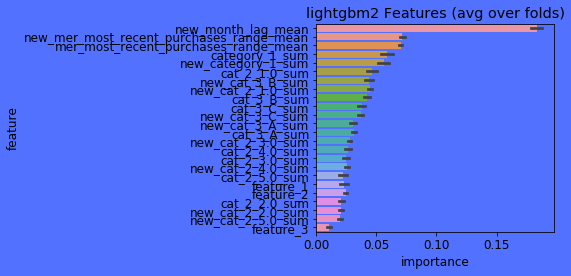

In [40]:
for i in range(len(layer1_models)):
    feature_importance_df = feature_importance[i]
    cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(12,12))
    fig, ax = plt.subplots(facecolor='#5271ff')
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance",
                                               ascending=False))
  
   
# Specify background color for the axis/plot
    ax.set_facecolor('#5271ff')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#020301')
    ax.tick_params(axis='y', colors='#020301')
    
    plt.title('%s Features (avg over folds)' % layer1_names[i])
    plt.tight_layout()
    plt.savefig('%s_importances.png' % layer1_names[i], facecolor=fig.get_facecolor(), transparent=True)

#### Layer 1 summary

In [63]:
# Print first layer result
layer1 = pd.DataFrame()
layer1['models'] = layer1_names
layer1['CV_score'] = layer1_score
layer1

models  CV_score
0       myrfc  3.842104
1   lightgbm2  3.833073
2  mygradiant  3.856478

Text(0.5, 1.0, 'Pair-wise correlation')

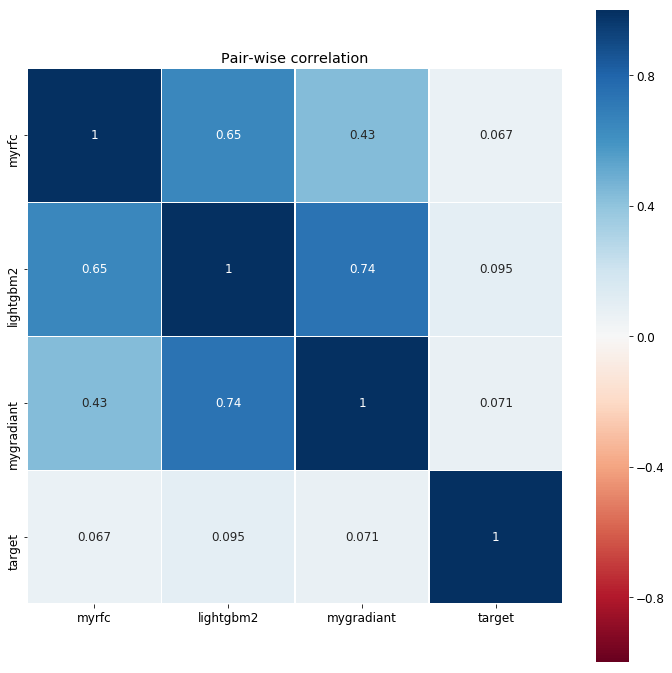

In [64]:
layer1_corr = pd.DataFrame()
for i in range(len(layer1_names)):
    layer1_corr[layer1_names[i]] = oof_train[:,i]
layer1_corr['target'] = target
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
sns.heatmap(layer1_corr.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

### Second layer

In [65]:
# Setup the model
ridge = Ridge(alpha=0.5)#, fit_intercept=False)
lasso = Lasso(alpha=0.5)
lars = Lars(fit_intercept=False, positive=True)
layer2_models = [lars, ridge, lasso]
layer2_names = ['Lars','ridge' , 'lasso']
#params_grid = {'alpha':[0.05,0.1,0.4,1.0]}

# Setup to record result
train_pred = np.zeros(len(train))
test_pred = np.zeros(len(test))

layer2 = pd.DataFrame()
layer2['models'] = layer2_names
layer2_score = []

In [66]:
# For regression

for i in range(len(layer2_models)):
    print('\n')
    name = layer2_names[i]
    model = layer2_models[i]
    print('Training %s' %name)
    #model, score = do_regressor((oof_train, target), model=model, parameters=params_grid)
    model.fit(oof_train, target)
    score = mean_squared_error(model.predict(oof_train), target)**0.5
    train_pred += model.predict(oof_train)/len(layer2_models)
    test_pred += model.predict(oof_test)/len(layer2_models)
    layer2_score.append(score)
    print('Training score: %.5f' % score)

#layer2['CV score'] = layer2_score
#layer2

layer2_coef = pd.DataFrame()
layer2_coef['Name'] = layer1_names
layer2_coef['Coefficient'] = model.coef_
#layer2_coef['Coefficient'] = coef
layer2_coef



Training Lars
Training score: 3.83298


Training ridge
Training score: 3.83297


Training lasso
Training score: 3.85049


Name  Coefficient
0       myrfc          0.0
1   lightgbm2          0.0
2  mygradiant          0.0


 Percentage accuracy
0.00653139284767168
--- 0.263232946395874 seconds ---


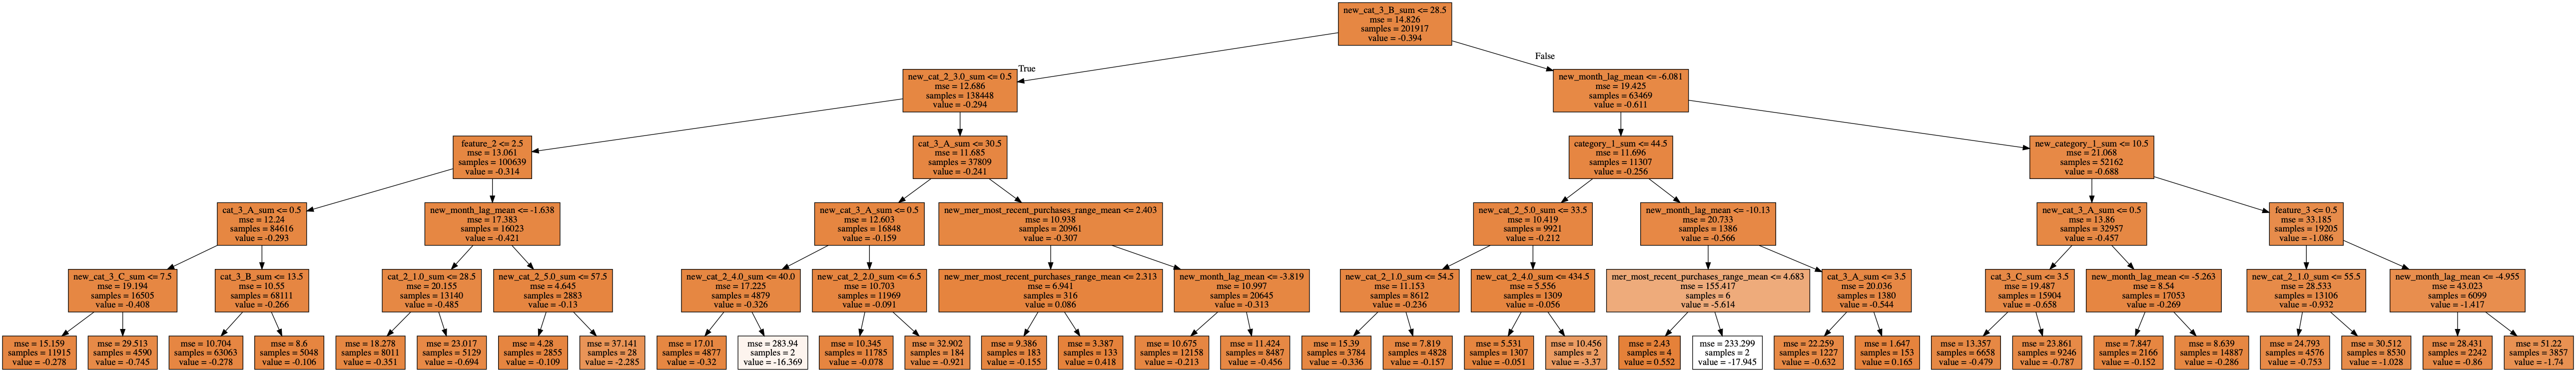

In [67]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeRegressor(
    criterion = 'mse',
    max_features=2,
    max_depth=5,
    random_state = 1337
)
start_time = time.time()
decision_tree.fit(train, target)

print('\n Percentage accuracy')
print(decision_tree.score(train, target))


print("--- %s seconds ---" % (time.time() - start_time))
# Render our tree.


dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=train.columns,
    class_names=['Target', 'Not Target'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [68]:
rfc = ensemble.RandomForestRegressor( criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)




In [45]:
#np.sum(model.coef_)

<Figure size 576x360 with 0 Axes>

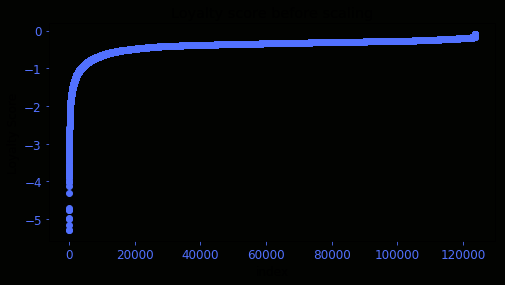

In [69]:
plt.figure(figsize=(8,5))
fig, ax = plt.subplots(facecolor='#020301')
plt.scatter(range(len(test_pred)), np.sort(test_pred), color= '#5271ff')   
ax.set_facecolor('#020301')
ax.set_clip_on(False)
ax.tick_params(axis='x', colors='#5271ff')
ax.tick_params(axis='y', colors='#5271ff')
plt.title('predicted output')
fig.savefig( "predicted output1.png", facecolor=fig.get_facecolor(), transparent=True)
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score before scaling')
plt.show()

<Figure size 576x360 with 0 Axes>

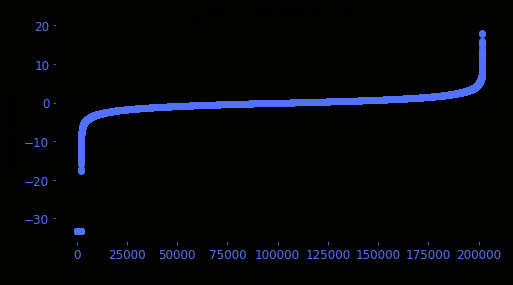

In [70]:
plt.figure(figsize=(8,5))
fig, ax = plt.subplots(facecolor='#020301')
plt.scatter(range(len(target)), np.sort(target), color= '#5271ff')   
ax.set_facecolor('#020301')
ax.set_clip_on(False)
ax.tick_params(axis='x', colors='#5271ff')
ax.tick_params(axis='y', colors='#5271ff')
plt.title(col)
fig.savefig(col + "1.png", facecolor=fig.get_facecolor(), transparent=True)
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score before scaling')
plt.show()

In [48]:
# Refit to the target
train_scaler = StandardScaler()
#train_scaler.fit(target.values.reshape(-1,1))
#test_pred = train_scaler.inverse_transform(test_pred.reshape(-1,1))

In [49]:
# Pushing min loyalty to -33.2
for i in range(len(test_pred)):
    if test_pred[i]<-12:
        test_pred[i] = target_min


NameError: name 'target_min' is not defined

### Data inferences

Here we see the distribution of the most important features and how they are different between highly loyal and highly un-loyal customer

In [50]:

df_important = df_train[features+['target']]

In [51]:
low_limit = -8
high_limit = 5
def discretize(x):
    if x<low_limit:
        return -1
    if x>high_limit:
        return 1
    else:
        return 0
    
df_important['target'] = df_important['target'].apply(lambda x: discretize(x))
df_important = df_important[df_important['target']!=0]
df_important = df_important.reset_index()

In [52]:
print('There are %i customers that has highly positive target' % len(df_important[df_important['target']==1]))
print('There are %i customers that has highly negative target' % len(df_important[df_important['target']==-1]))

There are 1742 customers that has highly positive target
There are 2399 customers that has highly negative target


<Figure size 576x288 with 0 Axes>

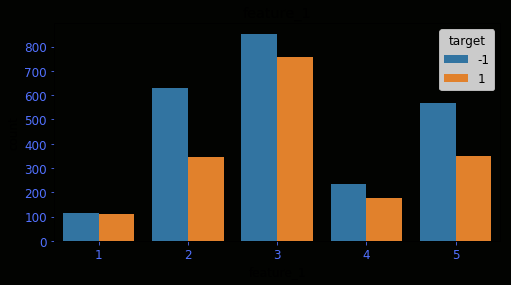

<Figure size 576x288 with 0 Axes>

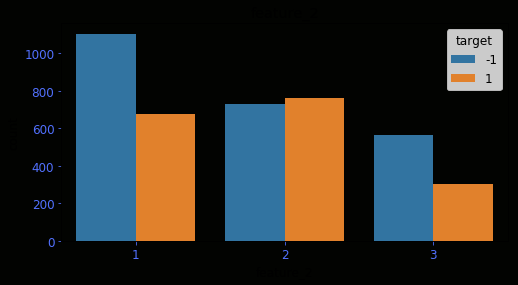

<Figure size 576x288 with 0 Axes>

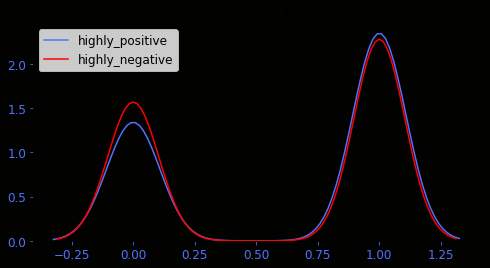

<Figure size 576x288 with 0 Axes>

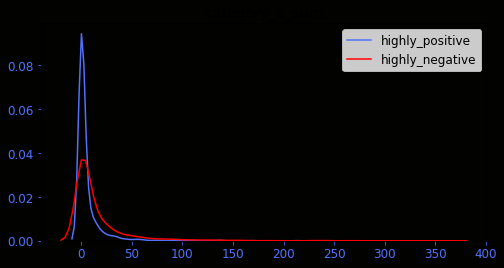

<Figure size 576x288 with 0 Axes>

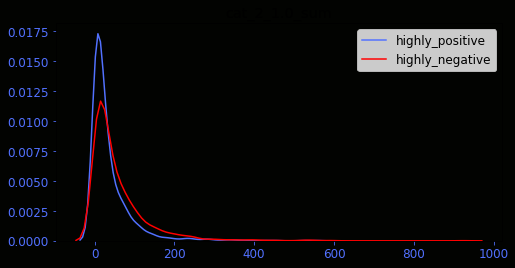

<Figure size 576x288 with 0 Axes>

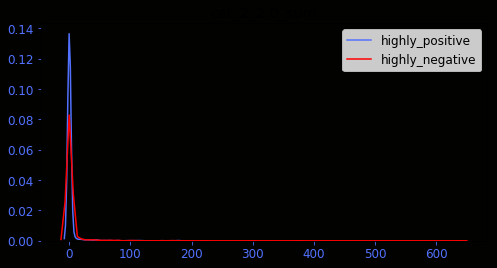

<Figure size 576x288 with 0 Axes>

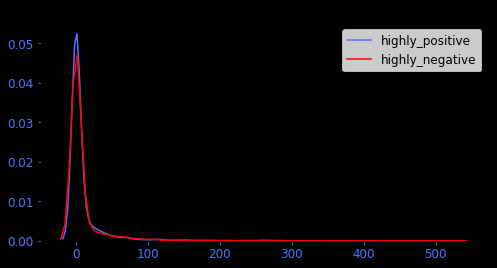

<Figure size 576x288 with 0 Axes>

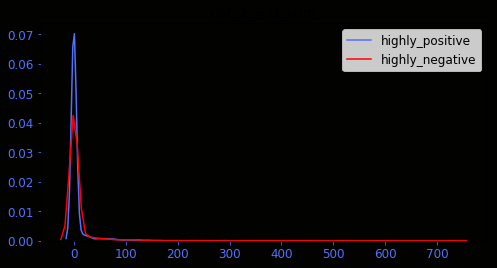

<Figure size 576x288 with 0 Axes>

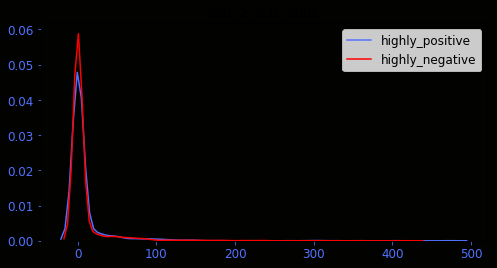

<Figure size 576x288 with 0 Axes>

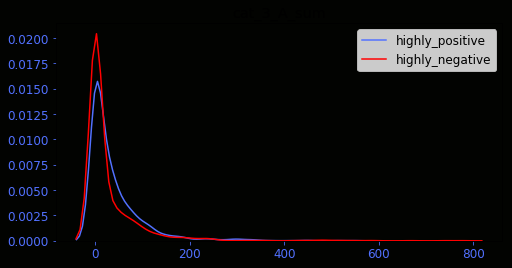

<Figure size 576x288 with 0 Axes>

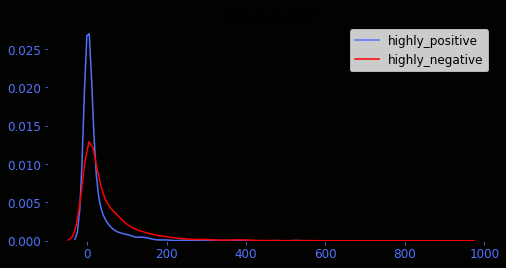

<Figure size 576x288 with 0 Axes>

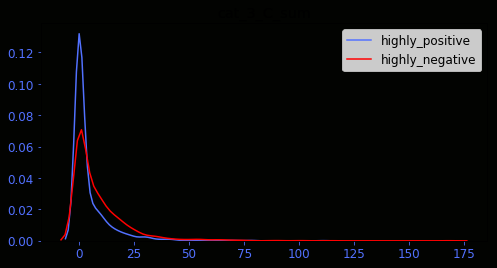

<Figure size 576x288 with 0 Axes>

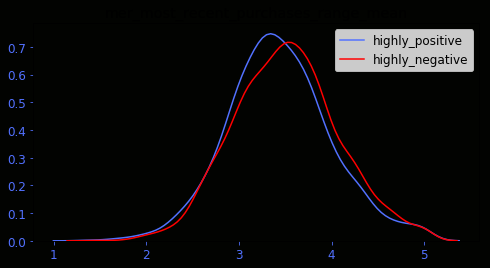

<Figure size 576x288 with 0 Axes>

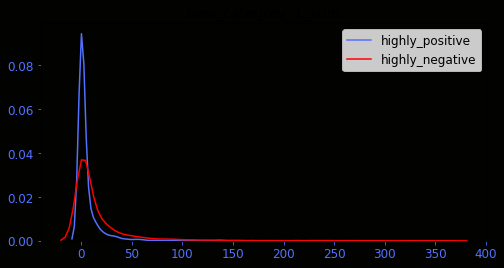

<Figure size 576x288 with 0 Axes>

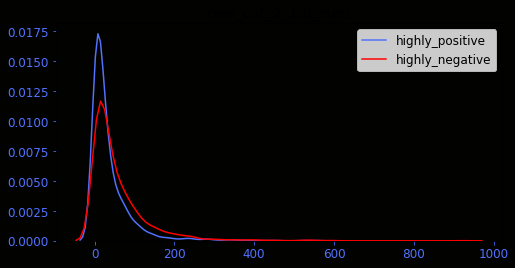

<Figure size 576x288 with 0 Axes>

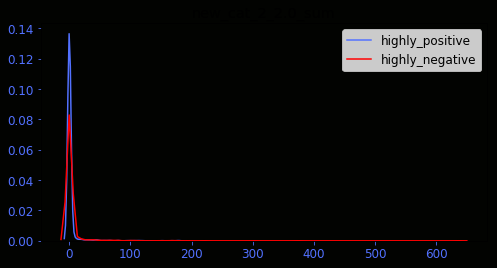

<Figure size 576x288 with 0 Axes>

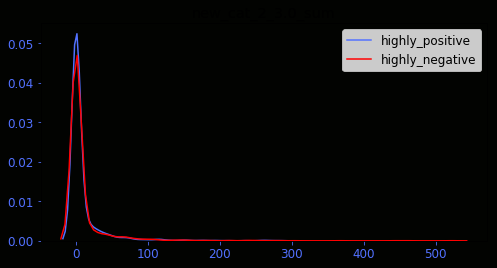

<Figure size 576x288 with 0 Axes>

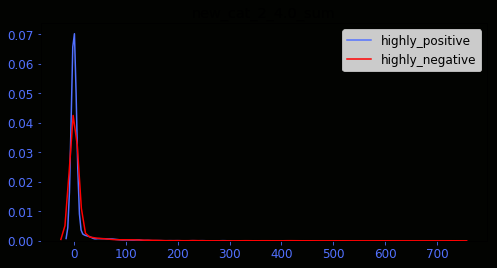

<Figure size 576x288 with 0 Axes>

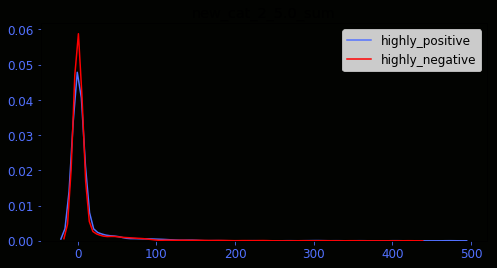

<Figure size 576x288 with 0 Axes>

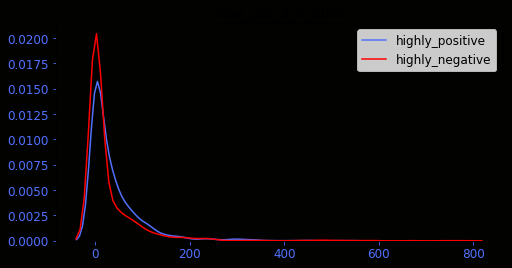

<Figure size 576x288 with 0 Axes>

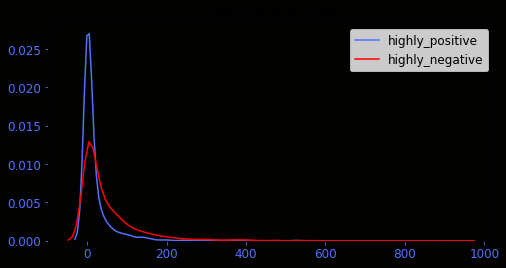

<Figure size 576x288 with 0 Axes>

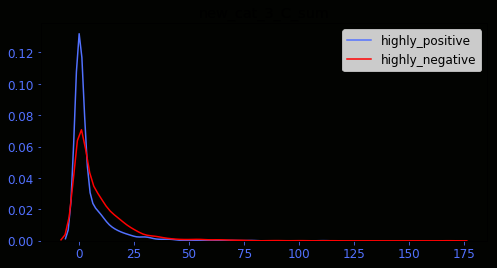

<Figure size 576x288 with 0 Axes>

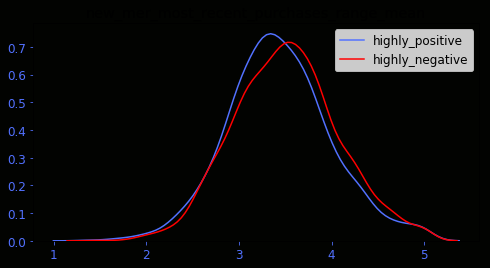

<Figure size 576x288 with 0 Axes>

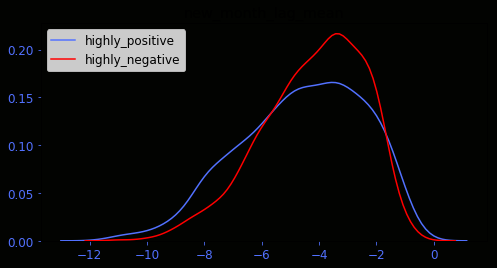

In [73]:
for col in features:
    if col not in ['feature_1', 'feature_2']:
        fig=plt.figure(figsize=(8,4))
        fig, ax = plt.subplots(facecolor='#020301')
        sns.kdeplot(df_important[df_important['target']==1][col], label='highly_positive', color= '#5271ff')
        sns.kdeplot(df_important[df_important['target']==-1][col], label='highly_negative', color = 'r')
        
        ax.set_facecolor('#020301')
        ax.set_clip_on(False)
        ax.tick_params(axis='x', colors='#5271ff')
        ax.tick_params(axis='y', colors='#5271ff')
        plt.title(col)
        fig.savefig(col + "1.png", facecolor=fig.get_facecolor(), transparent=True)
        #sns.kdeplot(df_important[df_important['target']==0][col], label='neutral')
        plt.title(col)
    else:
        fig=plt.figure(figsize=(8,4))
        fig, ax = plt.subplots(facecolor='#020301')
        sns.countplot(x=col, hue='target', data=df_important)
        ax.set_facecolor('#020301')
        ax.set_clip_on(False)
        ax.tick_params(axis='x', colors='#5271ff')
        ax.tick_params(axis='y', colors='#5271ff')
        plt.title(col)
        fig.savefig(col + "2.png", facecolor=fig.get_facecolor(), transparent=True)
        

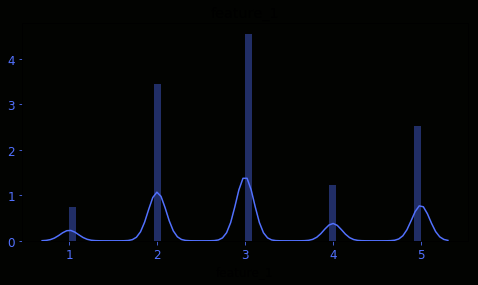

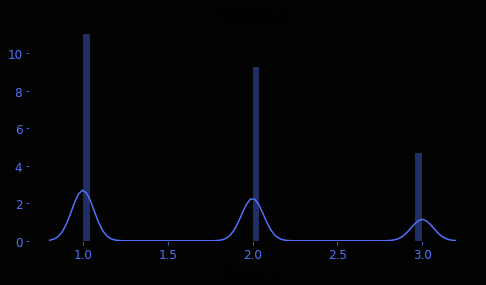

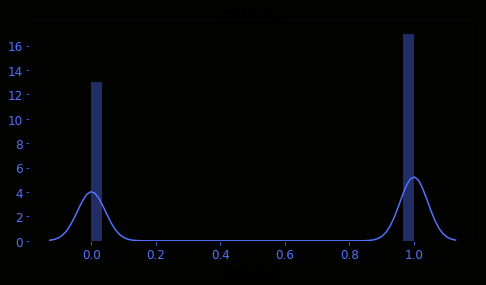

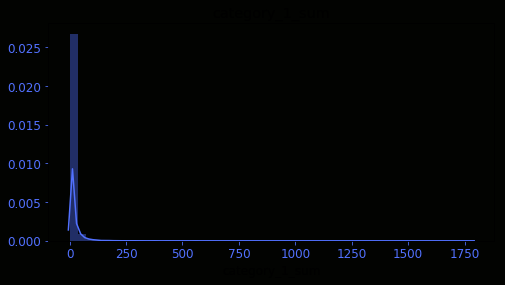

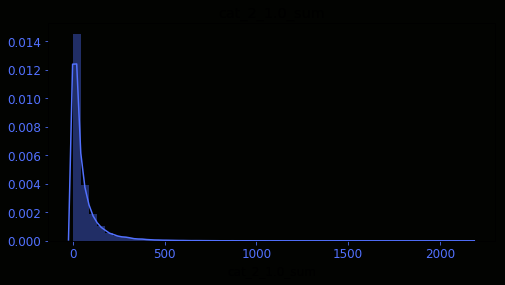

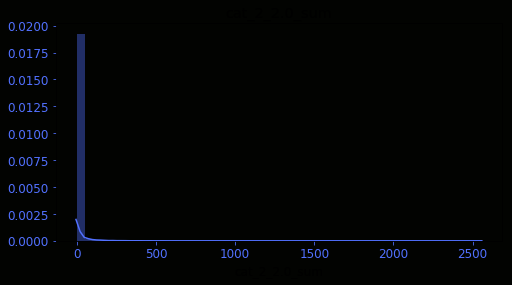

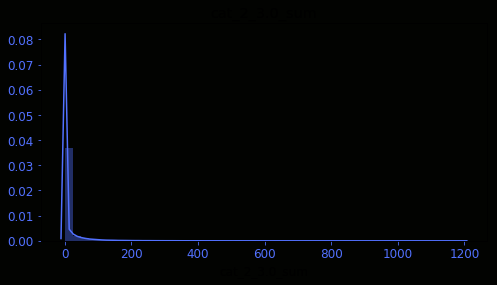

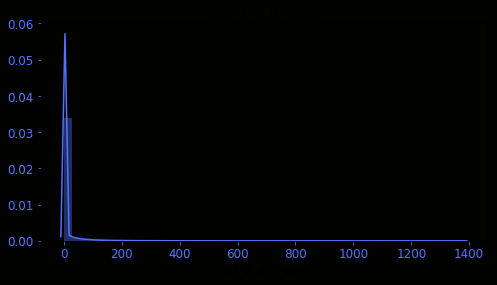

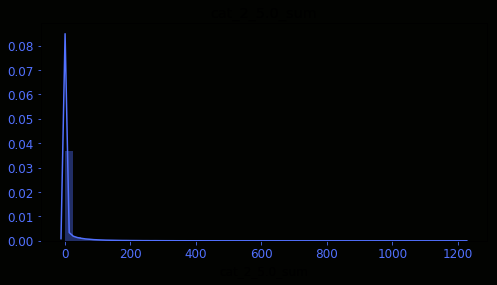

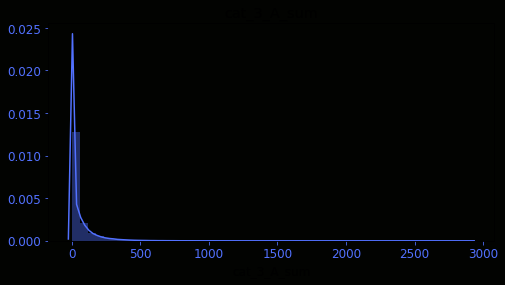

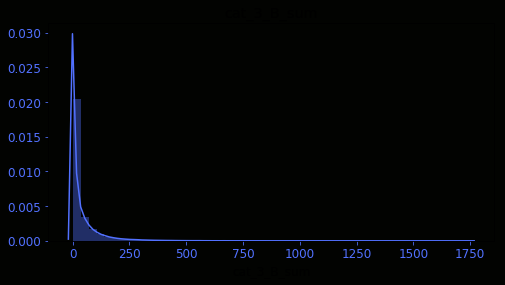

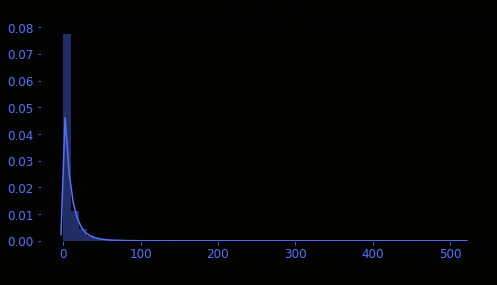

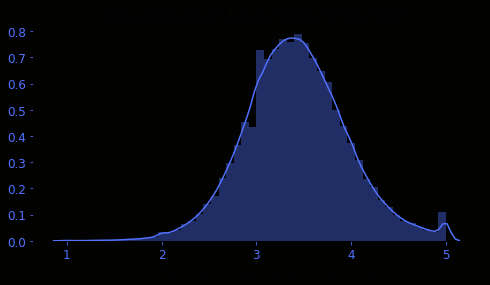

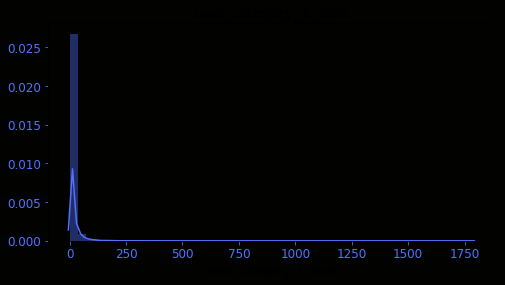

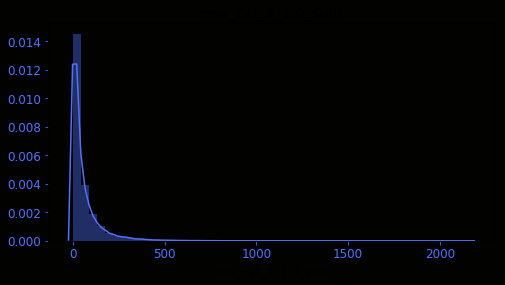

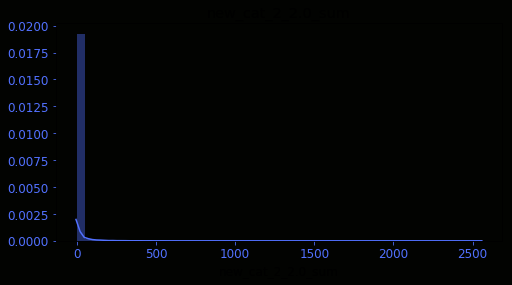

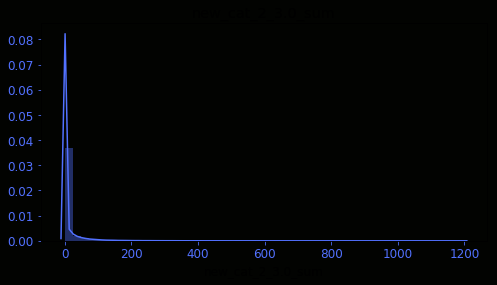

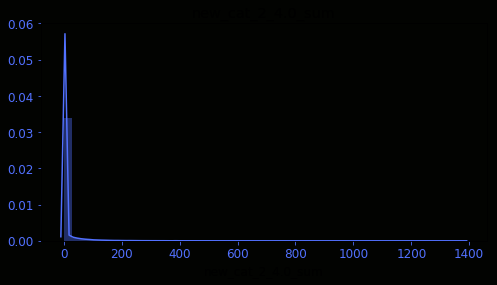

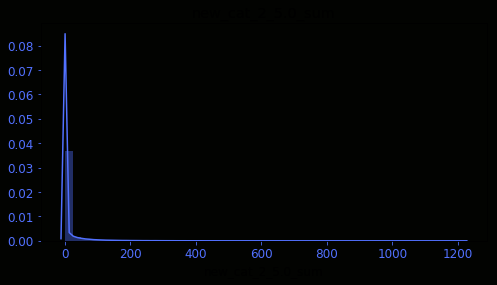

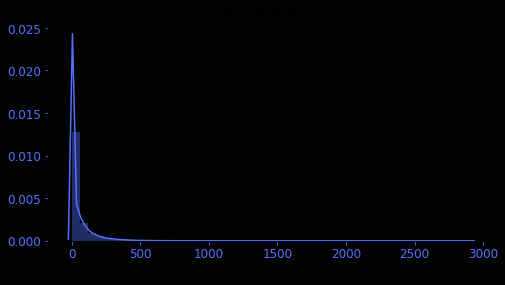

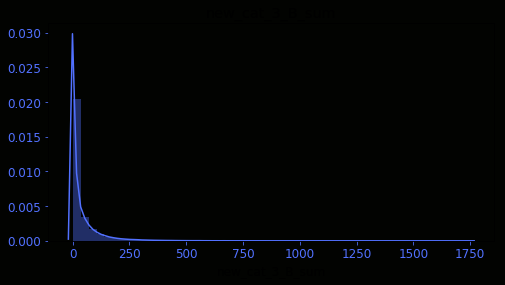

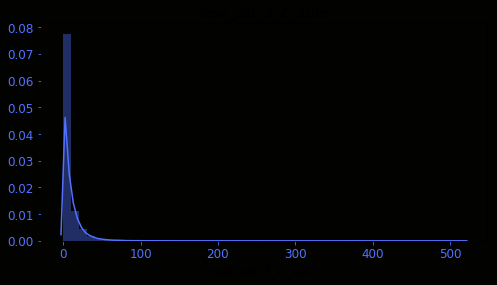

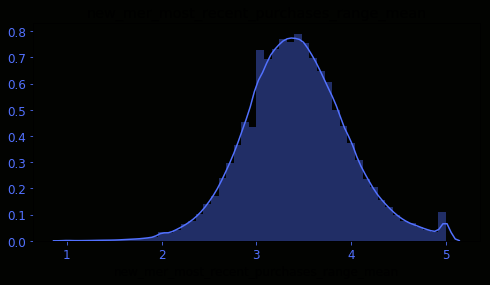

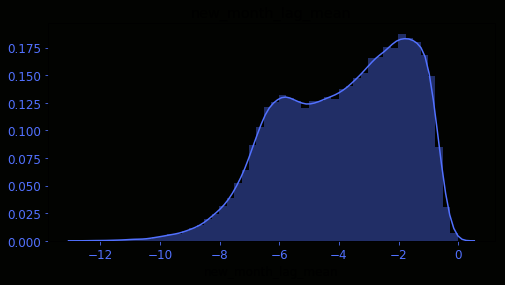

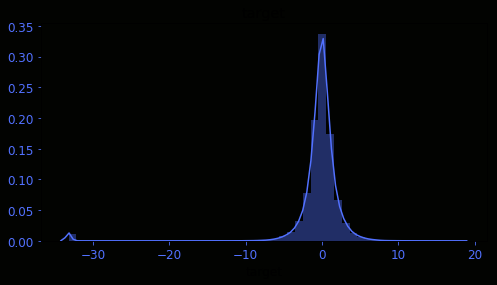

In [54]:
numerical_cols = features +['target']
for col in numerical_cols:
    # Specify facecolor when creating the figure
    fig, ax = plt.subplots(facecolor='#020301')
    sns.distplot(df_train[col], color='#5271ff')
   
# Specify background color for the axis/plot
    ax.set_facecolor('#020301')
    ax.set_clip_on(False)
    ax.tick_params(axis='x', colors='#5271ff')
    ax.tick_params(axis='y', colors='#5271ff')
    plt.title(col)
    
# Be sure to specify facecolor or it won't look right in Illustrator
    fig.savefig(col + "3.png", facecolor=fig.get_facecolor(), transparent=True)
    

In [ ]:
features

### Submission

In [ ]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = test_pred
sub_df.to_csv("submit.csv", index=False)

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(range(sub_df.shape[0]), np.sort(sub_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score after scaling')
plt.show()

In [ ]:
def prem (str1, str2):
    if sorted(list(str1)) == sorted(list(str2)):
        print (True)
    else:
        print(False)

In [ ]:
prem ('abca', 'bacd')

In [ ]:
def pal (str1):
    strlist = {}
    
    for i in sorted(list(str1)):
        if i in strlist.keys():
            del strlist[i]
        else:
            strlist[i] = i
    if (len(strlist) == 0 )| (len(strlist) == 1):
        print (True)
        
    else:
        print(False)
        
            
            
      

In [ ]:
pal('racecars')

In [ ]:
oof_train.head()